In [1]:
# Libraries
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.optimizers import RMSprop # Optimizer
import tensorflow as tf
from pickle import load
from google.colab import drive
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from numpy import array
from keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
# Load data and print examples
drive.mount('/content/drive')
Ruta_Archivo = '/content/drive/MyDrive/Ventas_Hora_V2.csv'

Mounted at /content/drive


In [3]:
# Load data
Datos=pd.read_csv(Ruta_Archivo,header=0, sep=";", decimal=".")
Datos.head()

,Fecha,Q_Ventas
0,1-6,10
1,1-7,29
2,1-8,68
3,1-9,60
4,1-10,58


Definición de CPU como device.

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

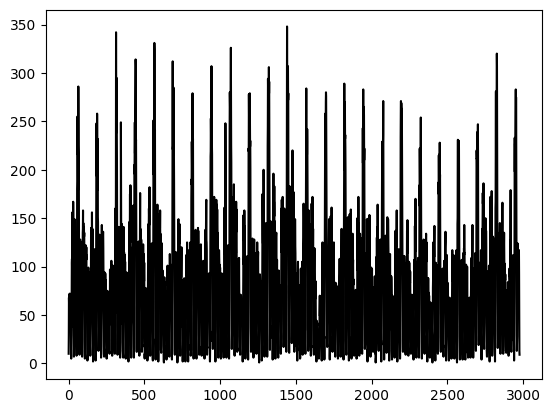

In [5]:
plt.plot(Datos['Q_Ventas'], color= 'black')

In [68]:
#Datos['Fecha'] = pd.to_datetime(
 #   Datos['Fecha'],
  #  format = '%d.%m.%Y'
#)

#plt.plot(Datos['Fecha'], Datos['Q_Ventas'])

In [ ]:
# Make date index

#Datos = Datos.set_index('Fecha')

Función para crear lags en el dataset


In [6]:
from copy import deepcopy as dc

def prepare_dataframe(df, n_steps):
    df = dc(Datos)

    df.set_index('Fecha', inplace=True)

    for i in range(1, n_steps+1):
        Datos[f'Q_Ventas(t-{i})'] = Datos['Q_Ventas'].shift(i)

    df.dropna(inplace=True)

    return df



In [8]:
TimeSteps = 7
SerieDesplazada = prepare_dataframe(Datos, TimeSteps)
SerieDesplazada

,Q_Ventas,Q_Ventas(t-1),Q_Ventas(t-2),Q_Ventas(t-3),Q_Ventas(t-4),Q_Ventas(t-5),Q_Ventas(t-6),Q_Ventas(t-7)
Fecha,,,,,,,,
1-13,50,72.0,66.0,58.0,60.0,68.0,29.0,10.0
1-14,53,50.0,72.0,66.0,58.0,60.0,68.0,29.0
1-15,63,53.0,50.0,72.0,66.0,58.0,60.0,68.0
1-16,72,63.0,53.0,50.0,72.0,66.0,58.0,60.0
1-17,38,72.0,63.0,53.0,50.0,72.0,66.0,58.0
...,...,...,...,...,...,...,...,...
14-19,117,111.0,106.0,81.0,117.0,108.0,73.0,108.0
14-20,92,117.0,111.0,106.0,81.0,117.0,108.0,73.0
14-21,39,92.0,117.0,111.0,106.0,81.0,117.0,108.0


Convierto a numpy para usar arrays

In [9]:
DesplazadaNp = SerieDesplazada.to_numpy()

DesplazadaNp

array([[ 50.,  72.,  66., ...,  68.,  29.,  10.],
       [ 53.,  50.,  72., ...,  60.,  68.,  29.],
       [ 63.,  53.,  50., ...,  58.,  60.,  68.],
       ...,
       [ 39.,  92., 117., ...,  81., 117., 108.],
       [ 13.,  39.,  92., ..., 106.,  81., 117.],
       [  9.,  13.,  39., ..., 111., 106.,  81.]])

Obsérvese que se tiene el dataset en forma: observaciones, número de columnas

In [10]:
DesplazadaNp.shape

(2971, 8)

Escalado de data. Deboi pasar antes de array ya que el escaler no sirve para df, o si sirve, pero toca dar más vuelta.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
DesplazadaNp = scaler.fit_transform(DesplazadaNp)

DesplazadaNp

array([[-0.71757925, -0.5907781 , -0.62536023, ..., -0.61383285,
        -0.83861671, -0.9481268 ],
       [-0.70028818, -0.71757925, -0.5907781 , ..., -0.65994236,
        -0.61383285, -0.83861671],
       [-0.6426513 , -0.70028818, -0.71757925, ..., -0.67146974,
        -0.65994236, -0.61383285],
       ...,
       [-0.78097983, -0.47550432, -0.3314121 , ..., -0.5389049 ,
        -0.3314121 , -0.3832853 ],
       [-0.93083573, -0.78097983, -0.47550432, ..., -0.39481268,
        -0.5389049 , -0.3314121 ],
       [-0.95389049, -0.93083573, -0.78097983, ..., -0.36599424,
        -0.39481268, -0.5389049 ]])

In [12]:
X = DesplazadaNp[:, 1:]
y = DesplazadaNp[:, 0]

Creo lotes de 7-1, es decir, 7 datos y predigo 1. Luego el predicho pasa a ser parte del nuevo lote y asi sucesivamente.

In [13]:
X[0], y[0]

(array([-0.5907781 , -0.62536023, -0.67146974, -0.65994236, -0.61383285,
        -0.83861671, -0.9481268 ]),
 -0.7175792507204612)

In [14]:
X.shape, y.shape

((2971, 7), (2971,))

Crea una copia de los array anterioes pero girando la data. observe que el primer array tiene la estructura del anterior, pero del revés. Las redes LSTM (Long Short-Term Memory) están diseñadas para capturar dependencias a largo plazo en secuencias de datos. Invertir las secuencias temporales puede ser una técnica útil en ciertos casos para permitir que el modelo capte patrones en ambas direcciones (hacia adelante y hacia atrás en el tiempo).Al invertir las secuencias, se puede entrenar el modelo para aprender las dependencias temporales de manera más robusta. Esto es útil especialmente cuando se combinan con modelos bidireccionales (Bidirectional LSTM), aunque en este ejemplo específico no se menciona el uso de una capa bidireccional.

In [15]:
X = dc(np.flip(X, axis=1))
X

array([[-0.9481268 , -0.83861671, -0.61383285, ..., -0.67146974,
        -0.62536023, -0.5907781 ],
       [-0.83861671, -0.61383285, -0.65994236, ..., -0.62536023,
        -0.5907781 , -0.71757925],
       [-0.61383285, -0.65994236, -0.67146974, ..., -0.5907781 ,
        -0.71757925, -0.70028818],
       ...,
       [-0.3832853 , -0.3314121 , -0.5389049 , ..., -0.36599424,
        -0.3314121 , -0.47550432],
       [-0.3314121 , -0.5389049 , -0.39481268, ..., -0.3314121 ,
        -0.47550432, -0.78097983],
       [-0.5389049 , -0.39481268, -0.36599424, ..., -0.47550432,
        -0.78097983, -0.93083573]])

In [16]:
X.shape

(2971, 7)

In [17]:
X[0]

array([-0.9481268 , -0.83861671, -0.61383285, -0.65994236, -0.67146974,
       -0.62536023, -0.5907781 ])

Defino un bloque para Training.

In [18]:
split_index = int(len(X) * 0.95)

split_index

2822

In [19]:
len(Datos)


2978

In [20]:
Datos.describe()

,Q_Ventas,Q_Ventas(t-1),Q_Ventas(t-2),Q_Ventas(t-3),Q_Ventas(t-4),Q_Ventas(t-5),Q_Ventas(t-6),Q_Ventas(t-7)
count,2978.000000,2977.000000,2976.000000,2975.000000,2974.000000,2973.000000,2972.000000,2971.000000
mean,88.694090,88.720860,88.746304,88.763025,88.761937,88.752439,88.744953,88.739145
std,62.929562,62.923172,62.918428,62.922391,62.932944,62.941399,62.950667,62.960468
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
50%,82.000000,82.000000,82.500000,83.000000,82.500000,82.000000,82.000000,82.000000
75%,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
max,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000


Sepra el dataset en Trainig y test.

In [21]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2822, 7), (149, 7), (2822,), (149,))

Acá es importante recordar que se había creado x y y antes y tenían el mismo largo, solo que el train tiene 7 variables mientras que y solo tenía 1. Se deben crear subsets del mismo tamaño para la coherencia del modelado.

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2822, 149, 2822, 149)

Recordar que los modelos recurrentes requieren la estructura samples, timesteps, features. sine qua non

In [23]:
X_train = X_train.reshape((-1, TimeSteps, 1))
X_test = X_test.reshape((-1, TimeSteps, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2822, 7, 1), (149, 7, 1), (2822, 1), (149, 1))

Creo tensores. Esto convierte arrays a tipo tensor que es necesario para modelar. El .float es fundamental también dado que pytorch espera .flotante.

In [24]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2822, 7, 1]),
 torch.Size([149, 7, 1]),
 torch.Size([2822, 1]),
 torch.Size([149, 1]))

Convierto los subsets en estructura de serie de tiempo para usarlo en pytorch, esto se hace para mejorar eficiencia

In [25]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [26]:
train_dataset

Batchsize indica el tamaño de minilotes que irá tomando el modelo. Impacta el rendimiento del modelo. Dataloader es propio de pytorch para la gestión del subset

In [27]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


Creo el modelo,

In [30]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out



In [31]:
input_size = 1
hidden_size = 4
output_size = 1
num_layers = 1

In [32]:
model = RNNModel(input_size, hidden_size, output_size, num_layers)

In [33]:
# Agregar listas para almacenar la pérdida
train_losses = []
val_losses = []

Entrenamiento...

In [34]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0 # Inicializa una variable para acumular la pérdida a lo largo de los lotes en la época.

    for batch_index, batch in enumerate(train_loader): # Itera sobre los lotes de datos proporcionados por el train_loader. enumerate proporciona tanto el índice del lote (batch_index) como el lote en sí (batch).
        x_batch, y_batch = batch[0].to(device), batch[1].to(device) # Extrae las características (x_batch) y las etiquetas (y_batch) del lote y las mueve al dispositivo especificado (CPU o GPU).

        output = model(x_batch) # Realiza el paso hacia adelante (forward pass) a través del modelo con las características del lote, produciendo las predicciones (output).
        loss = loss_function(output, y_batch) # Calcula la pérdida entre las predicciones del modelo y las etiquetas verdaderas utilizando la función de pérdida definida (loss_function).
        running_loss += loss.item() # Acumula la pérdida del lote actual en running_loss

        optimizer.zero_grad() # Resetea los gradientes de los parámetros del modelo. Esto es necesario porque por defecto, PyTorch acumula los gradientes.
        loss.backward() # Calcula los gradientes de la pérdida respecto a los parámetros del modelo (backward pass).
        optimizer.step() # Actualiza los parámetros del modelo utilizando los gradientes calculados.

        # Calcular la pérdida promedio del epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)


        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100 #Comprueba si el índice del lote es un múltiplo de 100 (menos 1 debido a que batch_index comienza en 0). Esto asegura que se imprime la pérdida cada 100 lotes.

            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

Validación...

In [35]:
def validate_one_epoch():
    model.train(False) # Pone el modelo en modo de evaluación (en contraste con el modo de entrenamiento que se usa con model.train(True)). Esto asegura que capas como Dropout y BatchNorm se comporten de manera determinista durante la evaluación.
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad(): # Temporalmente deshabilita el cálculo y almacenamiento de gradientes en PyTorch para reducir el uso de memoria y acelerar el cálculo. Esto es útil durante la evaluación cuando no necesitamos ajustar los pesos del modelo.
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    # Calcular la pérdida promedio del epoch
    epoch_loss = running_loss / len(test_loader)
    val_losses.append(epoch_loss)

    avg_loss_across_batches = running_loss / len(test_loader)
    val_losses.append(epoch_loss)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [36]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss() #  calcula el error cuadrático medio entre las predicciones y las etiquetas verdaderas.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.646

Val Loss: 0.177
***************************************************

Epoch: 2
Batch 100, Loss: 0.141

Val Loss: 0.089
***************************************************

Epoch: 3
Batch 100, Loss: 0.089

Val Loss: 0.059
***************************************************

Epoch: 4
Batch 100, Loss: 0.059

Val Loss: 0.045
***************************************************

Epoch: 5
Batch 100, Loss: 0.048

Val Loss: 0.040
***************************************************

Epoch: 6
Batch 100, Loss: 0.042

Val Loss: 0.037
***************************************************

Epoch: 7
Batch 100, Loss: 0.038

Val Loss: 0.034
***************************************************

Epoch: 8
Batch 100, Loss: 0.035

Val Loss: 0.032
***************************************************

Epoch: 9
Batch 100, Loss: 0.034

Val Loss: 0.030
***************************************************

Epoch: 10
Batch 100, Loss: 0.031

Val Loss: 0.029
********************************

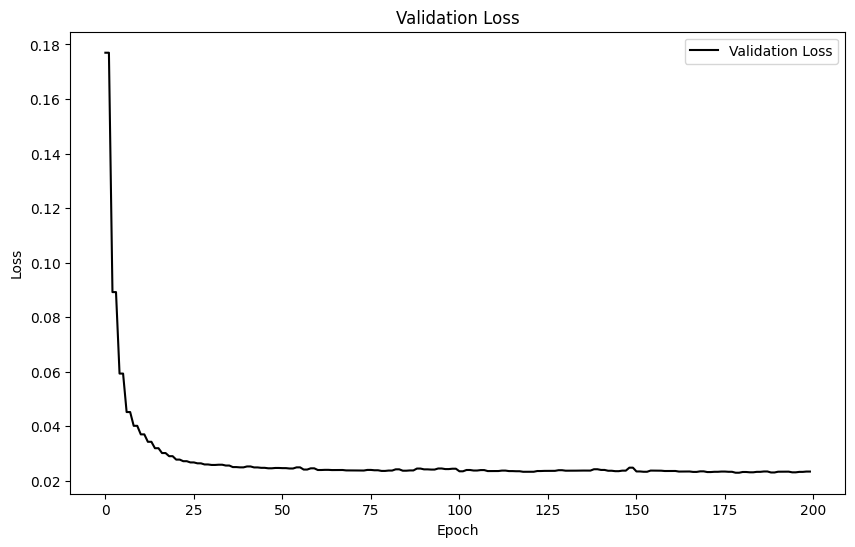

In [38]:
plt.figure(figsize=(10, 6))
#plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss',color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

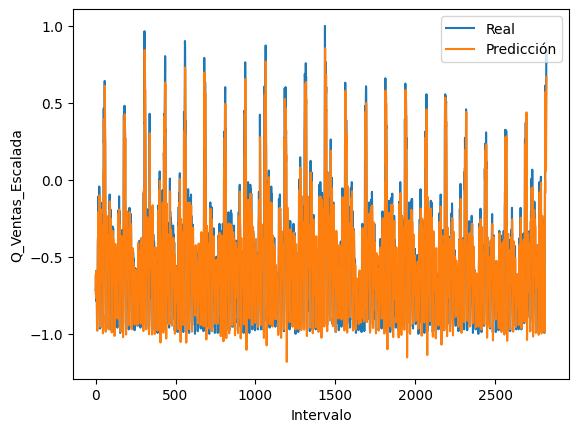

In [39]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Real')
plt.plot(predicted, label='Predicción')
plt.xlabel('Intervalo')
plt.ylabel('Q_Ventas_Escalada')
plt.legend()
plt.show()

Escalado inverso para las predicciones

In [ ]:
#train_predictions = predicted.flatten() # flatten() se utiliza para convertir predicted en una matriz unidimensional (aplanada).

#Ajuste = np.zeros((X_train.shape[0], TimeSteps+1)) #  Crea una matriz de ceros de tamaño (X_train.shape[0], lookback+1
#Ajuste[:, 0] = train_predictions # Asigna las predicciones a la primera columna
#Ajuste = scaler.inverse_transform(Ajuste) # Escalado inverso

#train_predictions = dc(Ajuste[:, 0])
#train_predictions

In [ ]:
#Ajuste = np.zeros((X_train.shape[0], TimeSteps+1))
#Ajuste[:, 0] = y_train.flatten()
#Ajuste = scaler.inverse_transform(Ajuste)

#new_y_train = dc(Ajuste[:, 0])
#new_y_train

array([ 50.00000089,  53.00000137,  62.99999607, ..., 283.00000346,
       320.00000244, 306.99999693])

In [40]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

Ajuste = np.zeros((X_test.shape[0], TimeSteps+1))
Ajuste[:, 0] = test_predictions
Ajuste = scaler.inverse_transform(Ajuste)

test_predictions = dc(Ajuste[:, 0])
test_predictions

array([ 2.79811810e+02,  2.08940062e+02,  1.38879943e+02,  3.03363864e+01,
        3.69493935e+00,  5.70444425e+01,  6.36420216e+01,  9.61612755e+01,
        1.34986553e+02,  1.14234268e+02,  1.18037873e+02,  8.43804804e+01,
        7.68585244e+01,  1.00018811e+02,  1.04908554e+02,  6.85001038e+01,
        3.12187979e+01,  1.10809194e+02,  1.38596536e+02,  1.37950054e+02,
        8.65822071e+01,  3.16324955e+01, -2.34720284e+00,  1.66806841e+01,
        5.88244880e+01,  9.29899180e+01,  9.55403775e+01,  1.16641173e+02,
        1.24329088e+02,  1.29729784e+02,  1.05165062e+02,  1.13735916e+02,
        8.79046919e+01,  9.95785052e+01,  1.29733000e+02,  1.49299116e+02,
        1.57382343e+02,  1.36937444e+02,  8.71421942e+01,  5.10323628e+01,
        1.81874269e+01,  4.86924735e+00,  2.96823649e+01,  5.94989752e+01,
        9.77449429e+01,  1.38543702e+02,  1.25296051e+02,  1.30270919e+02,
        1.06317151e+02,  6.79119674e+01,  5.62282160e+01,  5.87011977e+01,
        9.68492686e+01,  

In [41]:
Ajuste = np.zeros((X_test.shape[0], TimeSteps+1))
Ajuste[:, 0] = y_test.flatten()
Ajuste = scaler.inverse_transform(Ajuste)

new_y_test = dc(Ajuste[:, 0])
new_y_test

array([225.00000113, 176.99999997, 100.99999866,  34.99999851,
        16.00000238,  22.00000334,  48.99999729,  85.99999627,
       100.00000022, 123.00000043,  82.00000253,  89.00000192,
       113.00000057, 110.99999852,  71.00000423,  40.99999946,
       134.99999975, 133.0000003 , 144.99999962,  90.00000036,
        36.99999538,  11.9999983 ,  10.00000143,  22.00000334,
        40.99999946,  68.00000376, 116.99999948, 126.99999934,
       136.00000077, 109.00000165, 127.99999778,  94.99999771,
       117.99999791, 141.99999914, 159.99999942, 165.99999973,
       146.00000064, 102.00000226,  73.0000011 ,  28.99999756,
        10.00000143,  11.00000504,  17.99999925,  56.99999511,
       120.99999839, 123.00000043, 134.99999975, 107.99999805,
        74.00000471,  73.0000011 ,  65.00000328, 103.0000007 ,
        86.99999988,  85.99999627,  92.0000024 ,  48.99999729,
        36.00000212,  22.9999966 ,  13.00000191,  13.99999517,
        11.00000504,  39.00000259,  39.99999586,  62.99

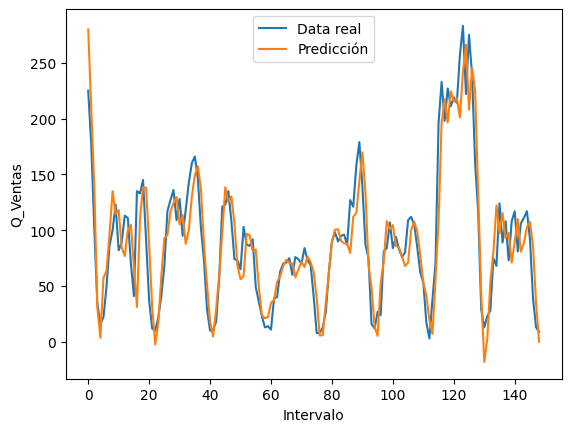

In [42]:
plt.plot(new_y_test, label='Data real')
plt.plot(test_predictions, label='Predicción')
plt.xlabel('Intervalo')
plt.ylabel('Q_Ventas')
plt.legend()
plt.show()


In [43]:
Media=np.mean(new_y_test)

In [44]:
Media

90.28859057952496

In [45]:
def calculate_mse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    return mse

In [46]:
MSE = calculate_mse(test_predictions, new_y_test)
print(f'MSE: {MSE:.2f}')

MSE: 709.86


In [47]:
# Suponiendo train_predictions y y_train son numpy arrays
def calculate_rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Ejemplo de uso
RSME = calculate_rmse(test_predictions, new_y_test)
print(f'RMSE: {RSME:.2f}')

RMSE: 26.64
